# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher20/Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

## 1. Configs

In [5]:
import random

options = {
    'MAX_EPOCHES': 250,
    'GAMMA': 0.99,
    'GAE_LAMBDA': 0.95,
    'TRAJECTORY_SIZE': 2048,
    'LR': 0.001,
    'PPO_EPS': 0.1,
    'PPO_EPOCHES': 10,
    'PPO_BATCH_SIZE': 128,
    'CKPT': 'model.pth',
    'SEED': 2,
    'HIDDEN_UNITS': 64,
    'ENTROPY_WEIGHT': 0.01,
}

print(options)

{'MAX_EPOCHES': 250, 'GAMMA': 0.99, 'GAE_LAMBDA': 0.95, 'TRAJECTORY_SIZE': 2048, 'LR': 0.001, 'PPO_EPS': 0.1, 'PPO_EPOCHES': 10, 'PPO_BATCH_SIZE': 128, 'CKPT': 'model.pth', 'SEED': 2, 'HIDDEN_UNITS': 64, 'ENTROPY_WEIGHT': 0.01}


## 2. Set Up

### Create Models and Optimizers

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

from models import ActorCritic

model = ActorCritic(state_size, action_size, options['SEED'], 
                    fc1_units=options['HIDDEN_UNITS'], fc2_units=options['HIDDEN_UNITS'])
model_optimizer = optim.Adam(model.parameters(), lr=options['LR'])


### Create Trainer and train

In [7]:
from trainer import Trainer

trainer = Trainer(env, model, model_optimizer, options)
mean_rewards, last_100_mean_rewards = trainer.train()

Episode 10	Recent Score: 1.15	Average Score: 0.81	Mean Value loss: 0.02005	Mean policy loss -0.04831
Episode 20	Recent Score: 3.16	Average Score: 1.60	Mean Value loss: 0.04867	Mean policy loss -0.04806
Episode 30	Recent Score: 5.42	Average Score: 2.57	Mean Value loss: 0.07977	Mean policy loss -0.04833
Episode 40	Recent Score: 9.81	Average Score: 3.97	Mean Value loss: 0.14299	Mean policy loss -0.04966
Episode 50	Recent Score: 17.45	Average Score: 5.98	Mean Value loss: 0.28322	Mean policy loss -0.04636
Episode 60	Recent Score: 23.13	Average Score: 8.45	Mean Value loss: 0.32907	Mean policy loss -0.04468
Episode 70	Recent Score: 26.31	Average Score: 10.79	Mean Value loss: 0.38484	Mean policy loss -0.04486
Episode 80	Recent Score: 29.35	Average Score: 12.94	Mean Value loss: 0.36921	Mean policy loss -0.04498
Episode 90	Recent Score: 30.55	Average Score: 14.82	Mean Value loss: 0.45829	Mean policy loss -0.04372
Episode 100	Recent Score: 34.48	Average Score: 16.65	Mean Value loss: 0.55330	Mean 

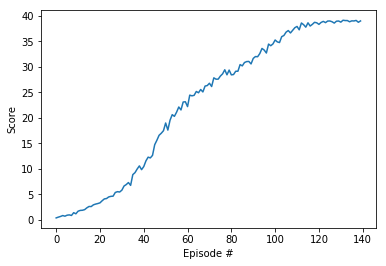

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.ion()
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(mean_rewards)), mean_rewards)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [10]:
env.close()